In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [193]:
#   2. Load Dataset
df= pd.read_csv("data/UCI_Credit_Card.csv")

In [194]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [195]:
df.shape

(30000, 25)

In [196]:
#  3. Basic Sanity Checks
TARGET = "default.payment.next.month"
assert TARGET in df.columns, "Target column not found!"

In [197]:
df=df.drop_duplicates()

In [198]:
# 4. Missing Values Handling (Defensive)

# Separate feature types
cat_cols = ["SEX", "EDUCATION", "MARRIAGE"]
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols = [x for x in num_cols if x not in cat_cols]
num_cols = [c for c in num_cols if c not in [TARGET]]

In [199]:
num_cols

['ID',
 'LIMIT_BAL',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [200]:
# Fill missing values with median (robust to outliers)
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())


In [201]:
# ---- Categorical Features ----
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [202]:
# EDUCATION: group rare/invalid value
df["EDUCATION"] = df["EDUCATION"].replace([0, 5, 6], 4)

In [203]:
# MARRIAGE: invalid value
df["MARRIAGE"] = df["MARRIAGE"].replace(0, 3)

In [204]:
for col in cat_cols:
    df[col] = df[col].astype("int")

In [205]:
unique_MARRIAGE = df['MARRIAGE'].unique()
print(sorted(unique_MARRIAGE))

[np.int64(1), np.int64(2), np.int64(3)]


In [206]:
unique_EDUCATION = df['EDUCATION'].unique()
print(sorted(unique_EDUCATION))

[np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [207]:
# 6. Outlier Handling (Winsorization)
# ======================================================
def outliers(series, lower=0.01, upper=0.99):
    low, high = series.quantile([lower, upper])
    return series.clip(low, high)

In [208]:
outlier_cols = [
    c for c in num_cols
    if c.startswith(("BILL_", "PAY_", "LIMIT_BAL"))
]
for col in outlier_cols:
    df[col] = outliers(df[col])

In [209]:
# 7. Feature Engineering
# ======================================================
bill_cols = [f"BILL_AMT{i}" for i in range(1, 7)]
pay_cols  = [f"PAY_AMT{i}" for i in range(1, 7)]
delay_cols = [f"PAY_{i}" for i in [0,2,3,4,5,6]]


In [210]:
# ---- Aggregations ----
df["TOTAL_BILL"] = df[bill_cols].sum(axis=1)
df["TOTAL_PAY"] = df[pay_cols].sum(axis=1)
df["PAY_RATIO"] = df["TOTAL_PAY"] / (df["TOTAL_BILL"] + 1)

In [211]:
# ---- Statistical Features ----
df["BILL_MEAN"] = df[bill_cols].mean(axis=1)
df["BILL_STD"]  = df[bill_cols].std(axis=1)
df["BILL_MAX"]  = df[bill_cols].max(axis=1)

df["PAY_MEAN"] = df[pay_cols].mean(axis=1)
df["PAY_STD"]  = df[pay_cols].std(axis=1)
df["PAY_MAX"]  = df[pay_cols].max(axis=1)

In [212]:
df["BILL_MEAN"]==df["TOTAL_BILL"]

0        False
1        False
2        False
3        False
4        False
         ...  
29995    False
29996    False
29997    False
29998    False
29999    False
Length: 30000, dtype: bool

In [213]:
# ---- Behavior Features ----
df["NB_LATE_PAYMENTS"] = (df[delay_cols] > 0).sum(axis=1)

In [214]:
# ---- Trend Features ----
df["BILL_TREND"] = df["BILL_AMT6"] - df["BILL_AMT1"]
df["PAY_TREND"]  = df["PAY_AMT6"] - df["PAY_AMT1"]

In [215]:
# 8. Skewness Handling (Log Transform)
# ======================================================
skewed_cols = [
    c for c in df.columns
    if c.startswith(("BILL_", "PAY_", "TOTAL_"))
]

for col in skewed_cols:
    df[col] = df[col].clip(lower=0)
    df[col] = np.log1p(df[col])


In [216]:
if "ID" in df.columns:
    df=df.drop(columns=["ID"])


In [217]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_RATIO,BILL_MEAN,BILL_STD,BILL_MAX,PAY_MEAN,PAY_STD,PAY_MAX,NB_LATE_PAYMENTS,BILL_TREND,PAY_TREND
0,20000.0,2,2,1,24,1.098612,1.098612,0.000000,0.0,0.0,...,0.085648,7.158514,7.474564,8.272315,4.752152,5.642910,6.536692,2,0.000000,0.000000
1,120000.0,2,2,2,26,0.000000,1.098612,0.000000,0.0,0.0,...,0.256791,7.954080,6.459854,8.147867,6.726633,6.625091,7.601402,2,6.363028,7.601402
2,90000.0,2,2,2,34,0.000000,0.000000,0.000000,0.0,0.0,...,0.102906,9.737620,8.710375,10.283293,7.516071,7.359350,8.517393,0,0.000000,8.155649
3,50000.0,2,2,1,37,0.000000,0.000000,0.000000,0.0,0.0,...,0.035617,10.559884,9.265472,10.805517,7.243513,6.171822,7.610853,0,0.000000,0.000000
4,50000.0,1,2,1,57,0.000000,0.000000,0.000000,0.0,0.0,...,0.431814,9.810504,9.275153,10.486708,9.194465,9.531498,10.510041,0,9.260558,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0.000000,0.000000,0.000000,0.0,0.0,...,0.057005,11.702657,11.370191,12.247051,8.866817,8.823989,9.903538,0,0.000000,0.000000
29996,150000.0,1,3,2,43,0.000000,0.000000,0.000000,0.0,0.0,...,0.521195,8.169431,8.071385,9.102755,7.789869,8.165228,9.104869,0,0.000000,0.000000
29997,30000.0,1,2,2,37,1.386294,1.386294,1.098612,0.0,0.0,...,0.367410,9.371637,9.143682,9.946499,8.559806,9.034926,9.998843,3,9.667322,8.039480
29998,80000.0,1,3,1,41,0.693147,0.000000,0.000000,0.0,0.0,...,0.389718,10.707658,10.390838,11.269324,9.966534,10.312097,11.105306,1,10.800106,0.000000


In [218]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month', 'TOTAL_BILL', 'TOTAL_PAY', 'PAY_RATIO',
       'BILL_MEAN', 'BILL_STD', 'BILL_MAX', 'PAY_MEAN', 'PAY_STD', 'PAY_MAX',
       'NB_LATE_PAYMENTS', 'BILL_TREND', 'PAY_TREND'],
      dtype='object')

In [219]:
df = df.drop(columns=bill_cols)


In [220]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month',
       'TOTAL_BILL', 'TOTAL_PAY', 'PAY_RATIO', 'BILL_MEAN', 'BILL_STD',
       'BILL_MAX', 'PAY_MEAN', 'PAY_STD', 'PAY_MAX', 'NB_LATE_PAYMENTS',
       'BILL_TREND', 'PAY_TREND'],
      dtype='object')

In [221]:
df = df.drop(columns=['TOTAL_BILL','TOTAL_PAY' ,'BILL_MAX','PAY_STD', 'PAY_MAX','PAY_MEAN','BILL_MEAN'])

In [222]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month',
       'PAY_RATIO', 'BILL_STD', 'NB_LATE_PAYMENTS', 'BILL_TREND', 'PAY_TREND'],
      dtype='object')

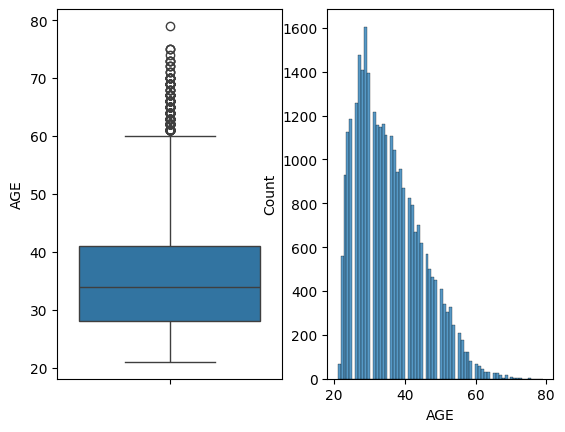

In [223]:
plt.Figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.boxplot(data=df['AGE'])
plt.title("")
plt.subplot(1,2,2)
sns.histplot(data=df['AGE'])
plt.show()

In [224]:
unique_ages = df['AGE'].unique().tolist()
print(sorted(unique_ages))

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 79]


In [225]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,PAY_RATIO,BILL_STD,NB_LATE_PAYMENTS,BILL_TREND,PAY_TREND
0,20000.0,2,2,1,24,1.098612,1.098612,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1,0.085648,7.474564,2,0.000000,0.000000
1,120000.0,2,2,2,26,0.000000,1.098612,0.000000,0.0,0.0,...,6.908755,6.908755,0.000000,7.601402,1,0.256791,6.459854,2,6.363028,7.601402
2,90000.0,2,2,2,34,0.000000,0.000000,0.000000,0.0,0.0,...,6.908755,6.908755,6.908755,8.517393,0,0.102906,8.710375,0,0.000000,8.155649
3,50000.0,2,2,1,37,0.000000,0.000000,0.000000,0.0,0.0,...,7.090910,7.003974,6.975414,6.908755,0,0.035617,9.265472,0,0.000000,0.000000
4,50000.0,1,2,1,57,0.000000,0.000000,0.000000,0.0,0.0,...,9.210440,9.105091,6.536692,6.522093,0,0.431814,9.275153,0,9.260558,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0.000000,0.000000,0.000000,0.0,0.0,...,8.517993,8.022241,8.517393,6.908755,0,0.057005,11.370191,0,0.000000,0.000000
29996,150000.0,1,3,2,43,0.000000,0.000000,0.000000,0.0,0.0,...,9.104869,4.867534,0.000000,0.000000,0,0.521195,8.071385,0,0.000000,0.000000
29997,30000.0,1,2,2,37,1.386294,1.386294,1.098612,0.0,0.0,...,9.998843,8.343078,7.601402,8.039480,1,0.367410,9.143682,3,9.667322,8.039480
29998,80000.0,1,3,1,41,0.693147,0.000000,0.000000,0.0,0.0,...,7.072422,7.563720,10.877387,7.498316,1,0.389718,10.390838,1,10.800106,0.000000


In [226]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month',
       'PAY_RATIO', 'BILL_STD', 'NB_LATE_PAYMENTS', 'BILL_TREND', 'PAY_TREND'],
      dtype='object')

In [227]:
df.to_csv('data/data_clean.csv',index=False)

In [228]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [229]:
num_cols

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default.payment.next.month',
 'PAY_RATIO',
 'BILL_STD',
 'NB_LATE_PAYMENTS',
 'BILL_TREND',
 'PAY_TREND']

In [230]:
num_cols = [x for x in num_cols if x not in cat_cols]
num_cols = [c for c in num_cols if c not in [TARGET]]

In [231]:
num_cols

['LIMIT_BAL',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'PAY_RATIO',
 'BILL_STD',
 'NB_LATE_PAYMENTS',
 'BILL_TREND',
 'PAY_TREND']

In [232]:
corr = df[num_cols].corr()

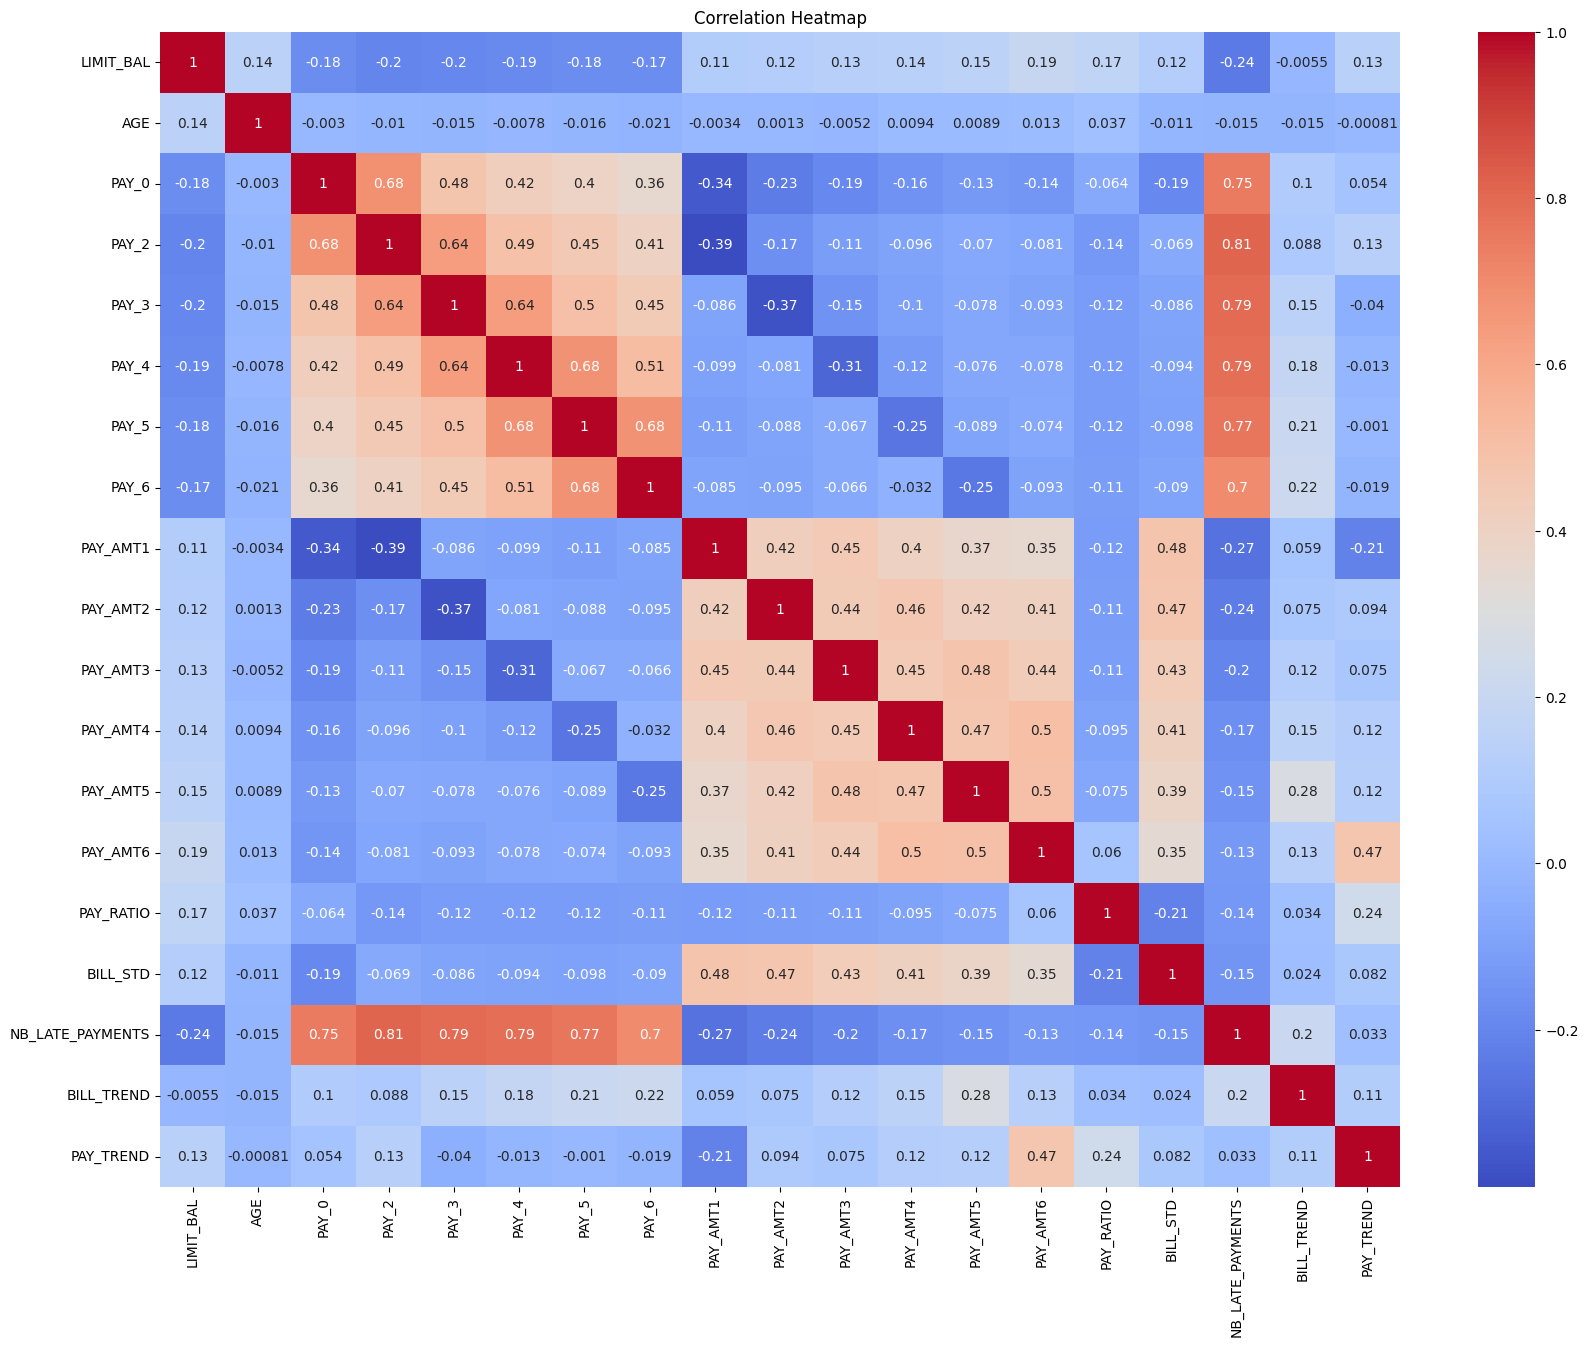

In [233]:
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()